In [68]:
%pip install deeptrack==0.11.3

import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
plt.style.use('default')

Note: you may need to restart the kernel to use updated packages.


In [69]:
IMAGE_SIZE = 256
FOURIER_IMAGE_SIZE = 40
SAMPLE_THICKNESS = 30

Om man väljer partikelradien till en meter, varför ser det normalt ut?

In [70]:
particle = dt.MieSphere(
    position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2, #lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * IMAGE_SIZE - IMAGE_SIZE / 2,
    z = lambda: np.random.uniform(-SAMPLE_THICKNESS / 2, SAMPLE_THICKNESS / 2),
    radius = lambda: (1.5e-7 + 3e-7 * np.random.rand()),
    refractive_index = lambda: np.random.rand() * 0.15 + 1.45,
    L = 8,
    position_unit = 'pixel'
)

In [71]:
HC = dt.HorizontalComa(coefficient= lambda c1: c1, c1 = 0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient= lambda c2: c2, c2 = 0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

CROP = dt.Lambda(crop, pupil_radius = 23)

optics = dt.Brightfield(
    NA = 1.3,
    resolution = 1.13e-6,
    wavelength= 635e-9,
    aperture_angle= 53.7 * 2 * np.pi / 360,
    polarization_angle= lambda: np.random.rand() * 2 * np.pi,
    magnification= 10,
    output_region= (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding= (64,) * 4,
    return_field = True,
    pupil = HC + VC + CROP
)

In [72]:
real_noise = dt.Gaussian(
    mu = 0,
    sigma = lambda level: np.random.rand() * 0.02
)

noise = real_noise + dt.Gaussian(
    mu = 0,
    sigma = lambda real_sigma: real_sigma * 0.03j,
    real_sigma = real_noise.sigma
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

In [73]:
def crop_image(image, CROPPED_SIZE):
    y, x, z = image.shape
    return image[
        (y // 2 - CROPPED_SIZE // 2):(y // 2 + CROPPED_SIZE // 2),
        (x // 2 - CROPPED_SIZE // 2):(x // 2 + CROPPED_SIZE // 2)
        ]

def fourier_transform_image(CROPPED_SIZE=IMAGE_SIZE):
    def inner(image):
        image -= np.mean(image)
        transformed_image = np.fft.fftshift(np.fft.fft2(image, axes=(0,1)))
        return crop_image(transformed_image, CROPPED_SIZE)
    return inner

fft = dt.Lambda(fourier_transform_image, CROPPED_SIZE=FOURIER_IMAGE_SIZE)

# FFT
Making a lambda feature that applies an FFT 

In [74]:
dataset = optics(particle**1 + noise) + fft + complex_to_float

In [75]:
dataset.update()
fft_image_of_particle = dataset.resolve()

(256, 256)


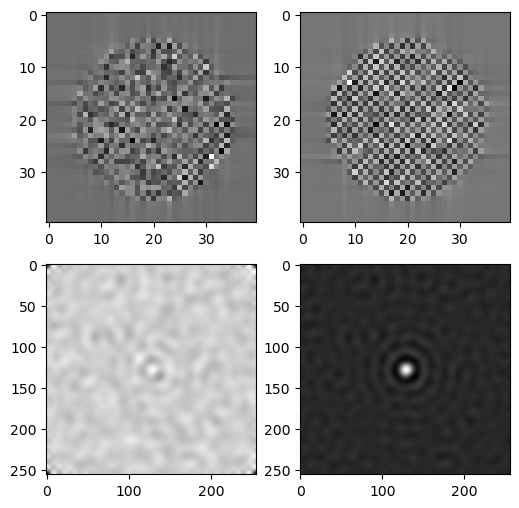

In [76]:

# image_of_particle[:, :, 0] = np.log(image_of_particle[:, :, 0] - np.min(image_of_particle[:, :, 0]))
#image_of_particle[x // 2, y // 2, 0] = 1
#fft_image_of_particle[:, :, 0] -= np.mean(fft_image_of_particle[:, :, 0])

dataset.update()
fft_image_of_particle = dataset.resolve()

plt.figure(figsize = (6, 6))

plt.subplot(2,2,1)
plt.imshow(fft_image_of_particle[:, :, 0], cmap = 'gray')

plt.subplot(2,2,2)
plt.imshow(fft_image_of_particle[:, :, 1], cmap = 'gray')

position_space_image = np.fft.ifft2(np.fft.ifftshift(np.pad((fft_image_of_particle[:, :, 0] + 1j * fft_image_of_particle[:, :, 1]), (IMAGE_SIZE - FOURIER_IMAGE_SIZE) // 2)))
print(position_space_image.shape)
real_position_space_image = np.real(position_space_image)
imag_position_space_image = np.imag(position_space_image)

plt.subplot(2,2,3)
plt.imshow(real_position_space_image, cmap = 'gray')

plt.subplot(2,2,4)
plt.imshow(imag_position_space_image, cmap = 'gray')

plt.show()

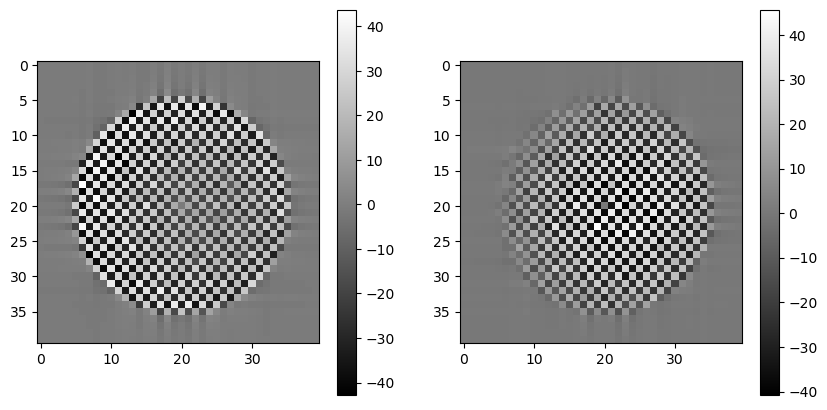

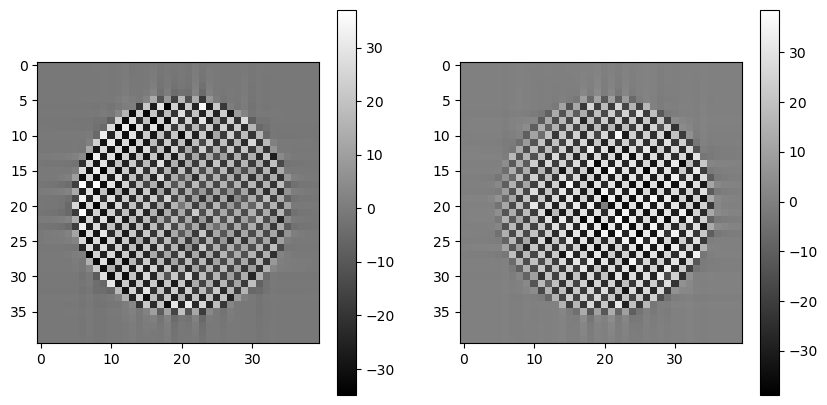

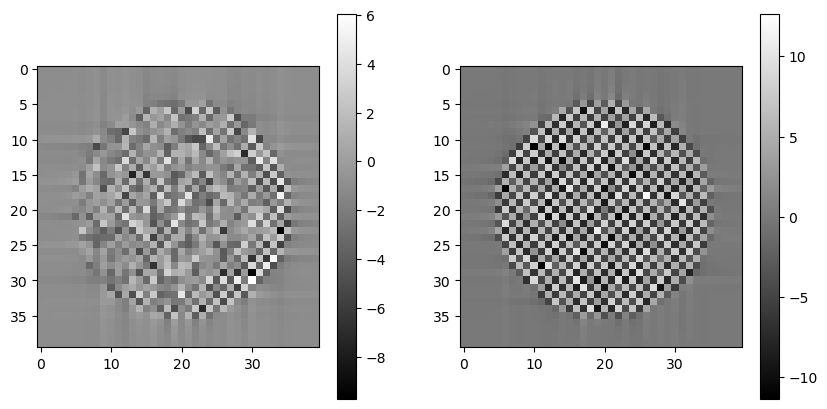

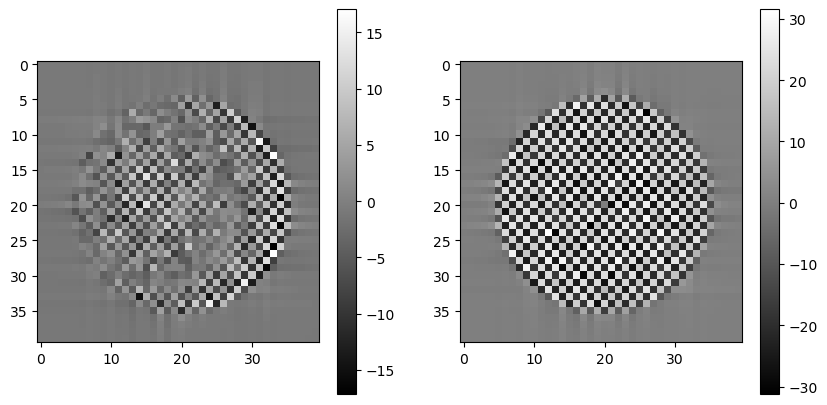

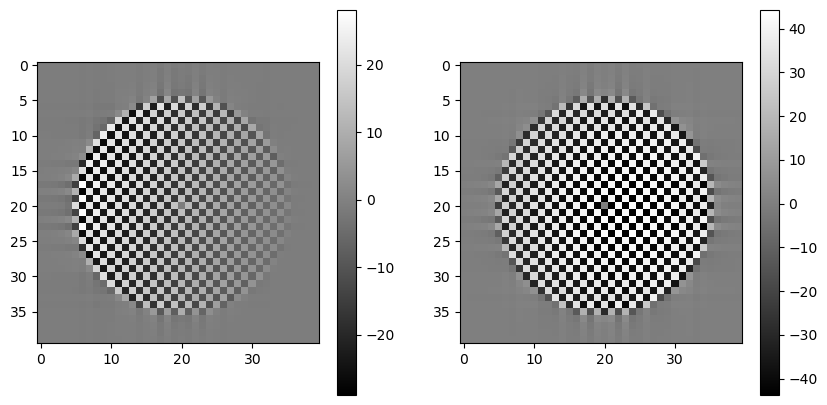

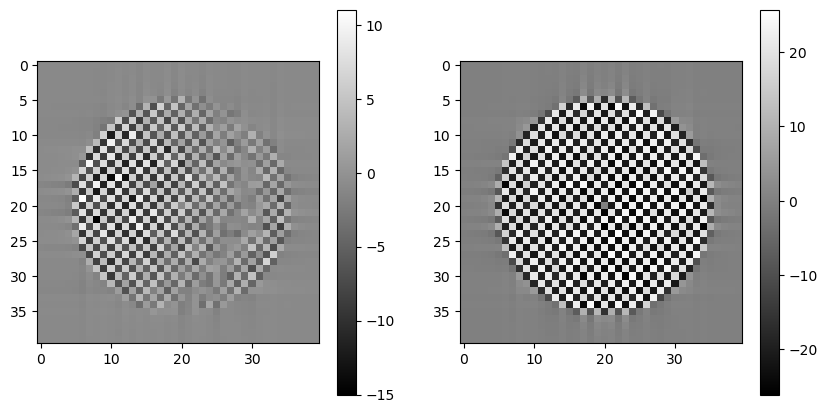

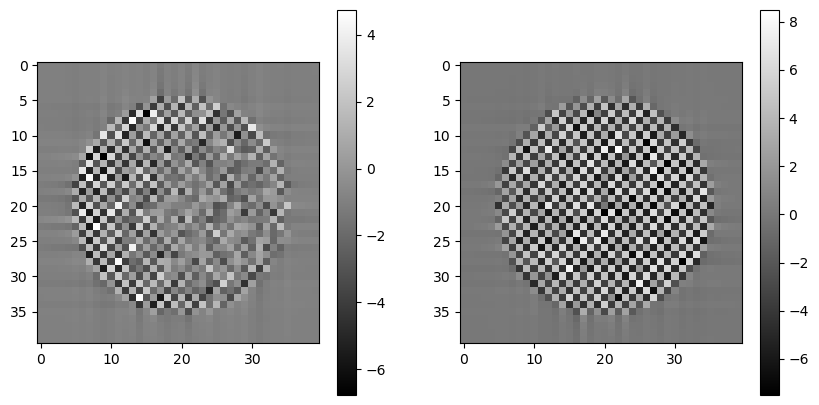

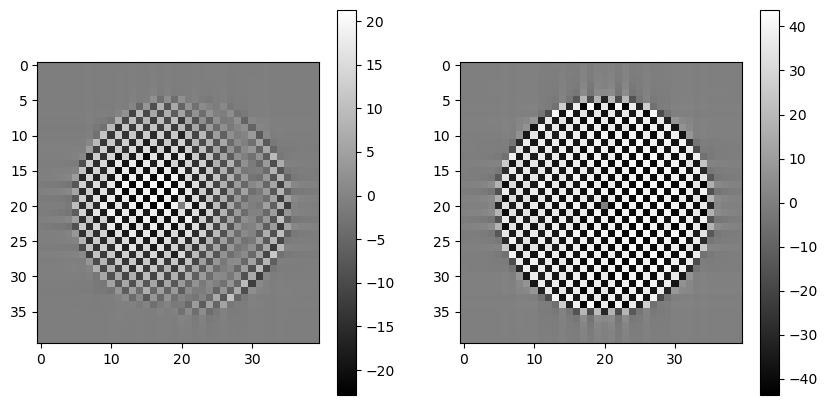

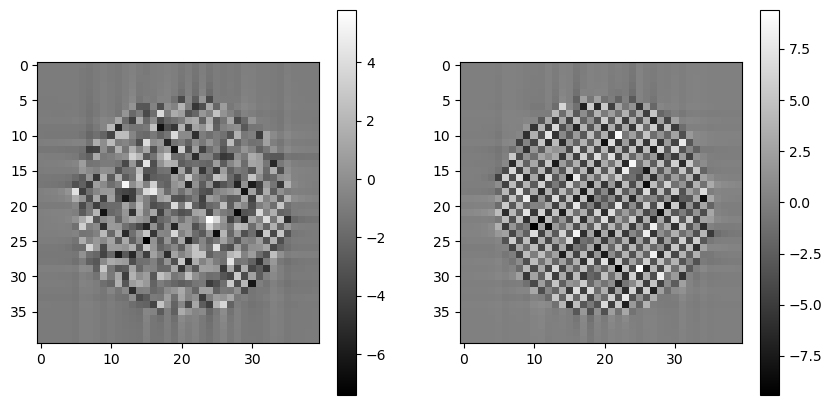

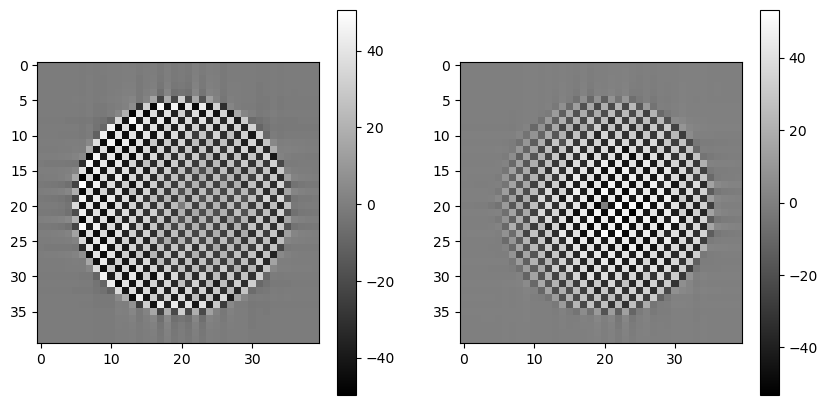

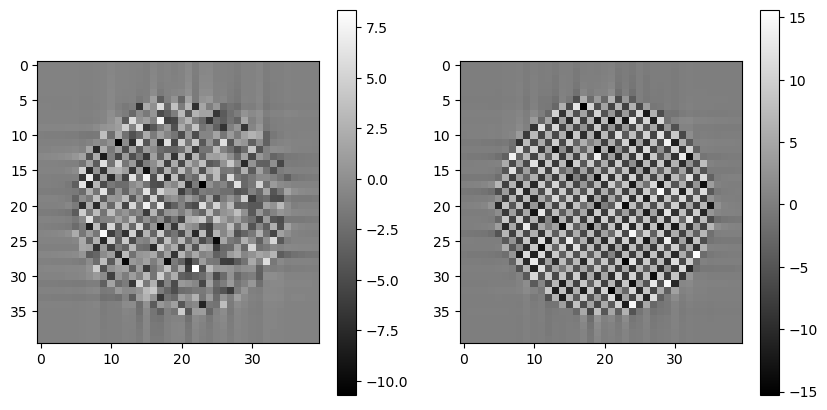

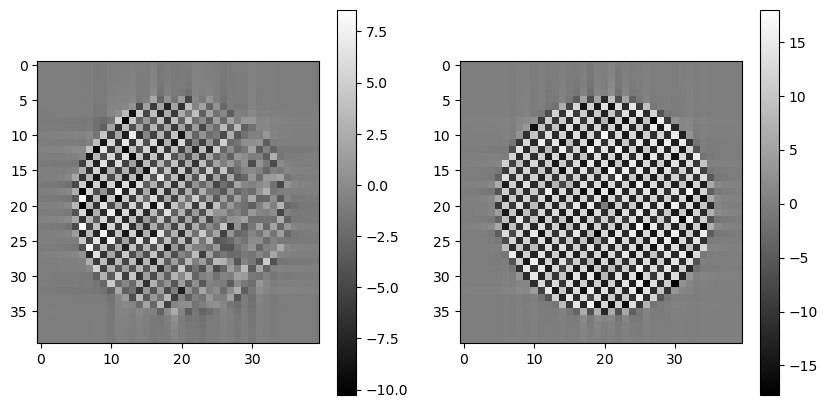

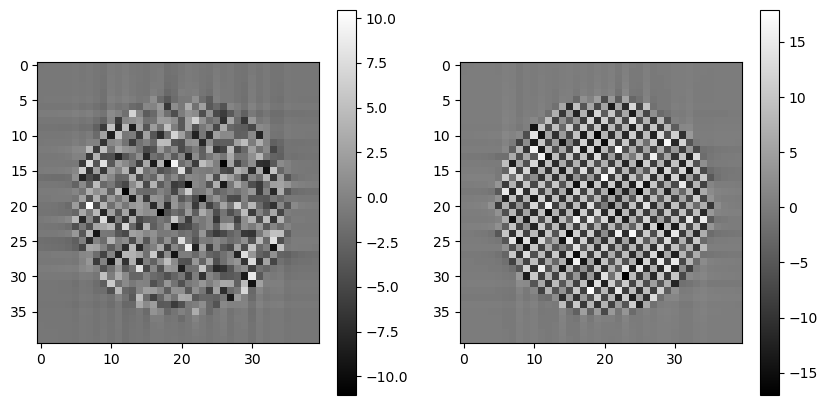

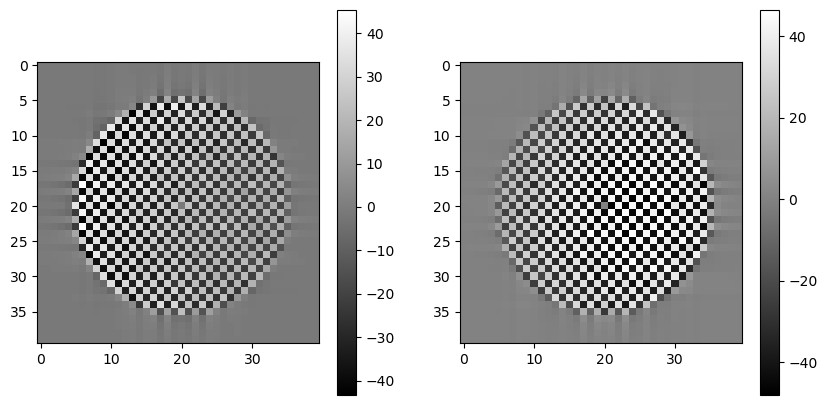

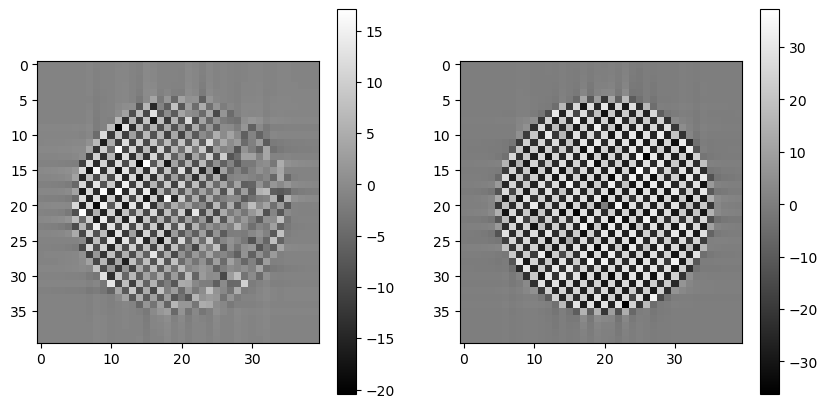

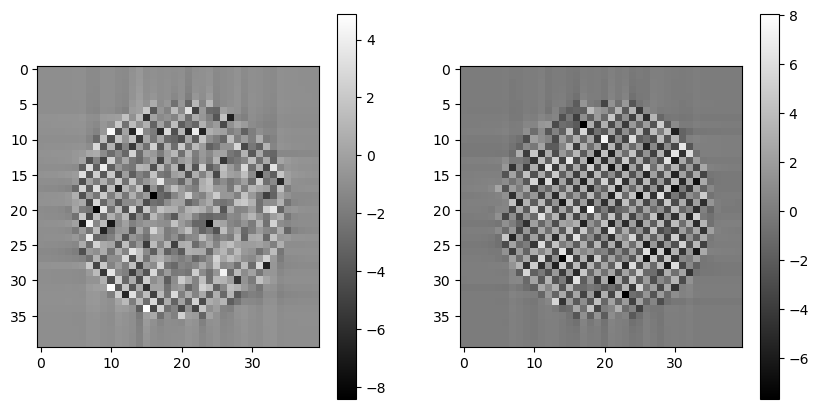

In [77]:
for i in range(16):
    dataset.update()
    image_of_particle = dataset.resolve()

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap = 'gray')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap = 'gray')
    plt.colorbar()
    
    plt.show()

### 2. Network design

In [78]:
def get_label(image):
    z = image.get_property('z')
    return z

In [113]:
import keras.backend as K
import keras.optimizers as optimizers

models = []

model = dt.models.Convolutional(
    input_shape= (FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE, 2),
    conv_layers_dimensions= (32, 64, 64, 64, 128),
    dense_layers_dimensions= (128, 64, 32, 16),
    steps_per_pooling= 2,
    number_of_outputs= 1,
    dropout= (.2, .2),
    loss= 'mae',
    optimizer= 'adam',
    dense_block= dt.layers.DenseBlock(activation='relu')
)
model.totalhistory = {"training_loss": [], "validation_loss": []}
models.append(model)

model= dt.models.FullyConnected(
    input_shape=(FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE, 2),
    dense_layers_dimensions=(128, 64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="sigmoid")
)
model.totalhistory = {"training_loss": [], "validation_loss": []}
models.append(model)

model = model= dt.models.FullyConnected(
    input_shape=(FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE, 2),
    dense_layers_dimensions=(128, 64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)
model.totalhistory = {"training_loss": [], "validation_loss": []}
models.append(model)


for model in models:
    print(model.name)

model_18
model_19
model_20


In [80]:
from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 256
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

In [82]:
def save_history(model):
    model.totalhistory["validation_loss"].extend(h.history["val_loss"])
    model.totalhistory["training_loss"].extend(h.history["loss"])

In [123]:
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size= int(64),
    max_data_size= int(2e3),
    batch_size= 64,
    verbose=0
)

In [118]:
from cycler import cycler
from IPython.display import display, clear_output

Generating 171 / 64 samples before starting training


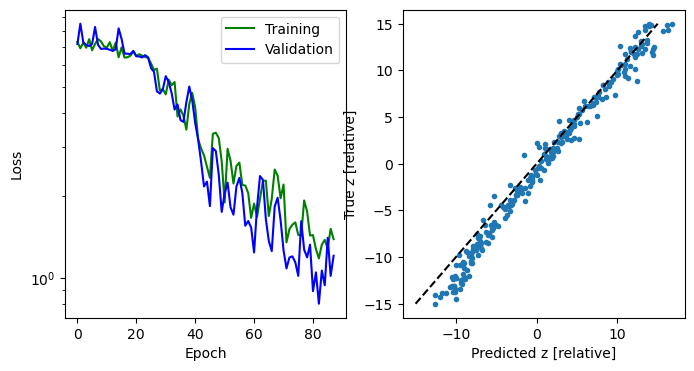

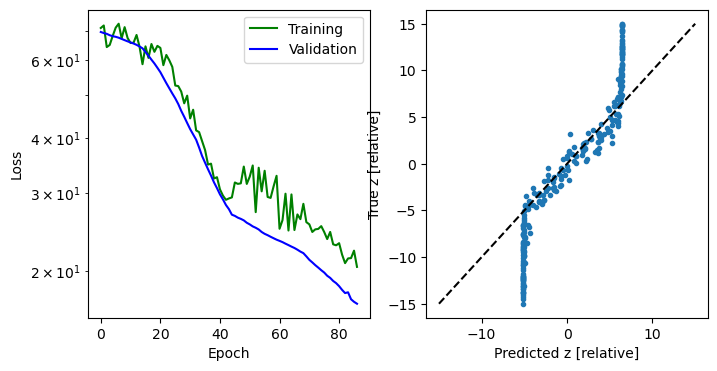

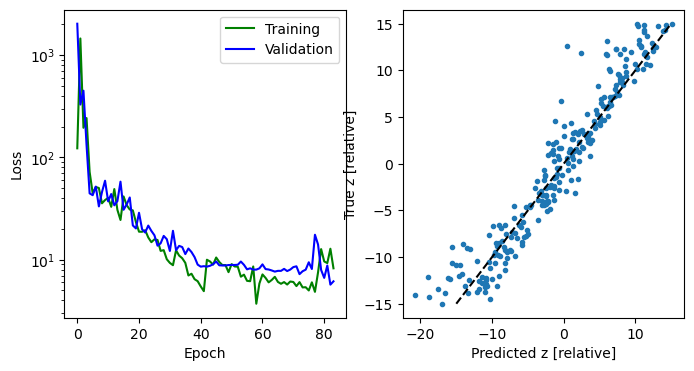

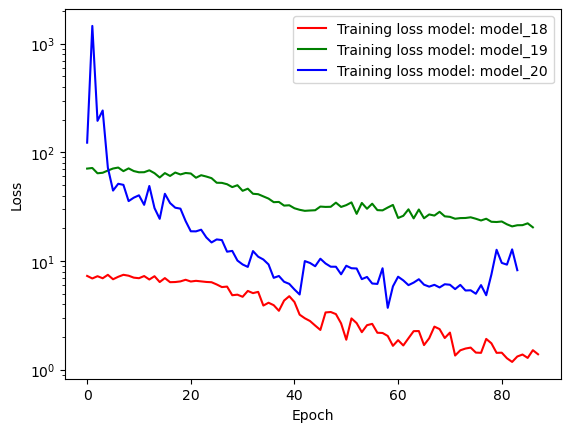

Generating 179 / 64 samples before starting training


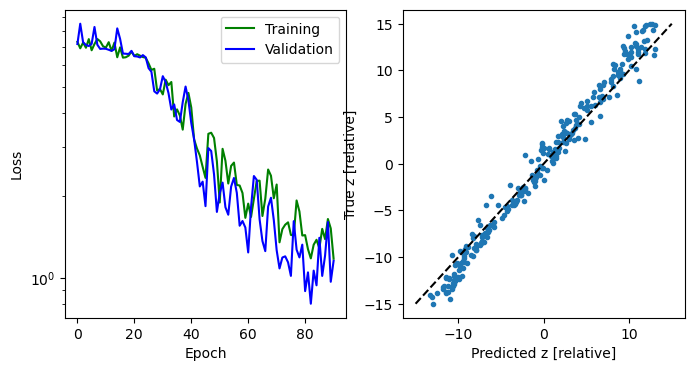

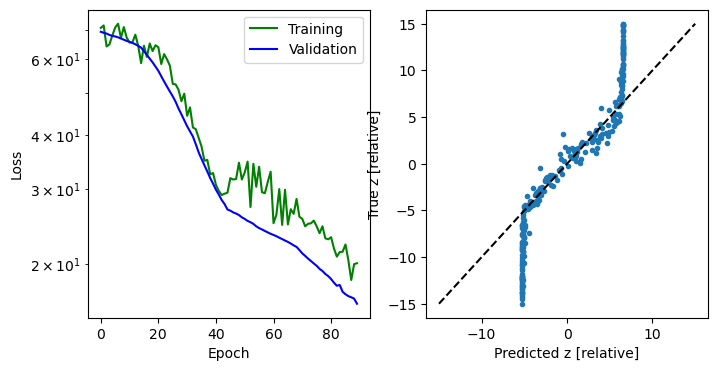

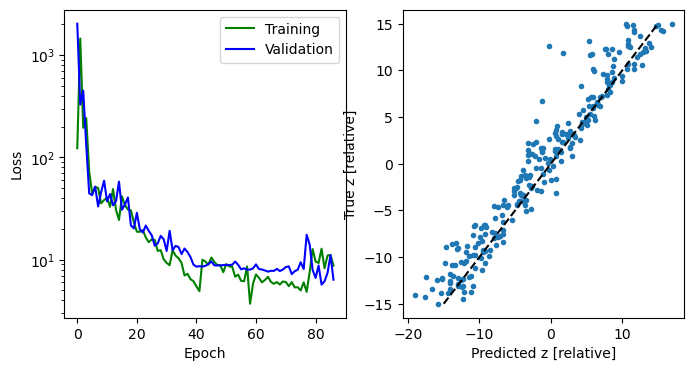

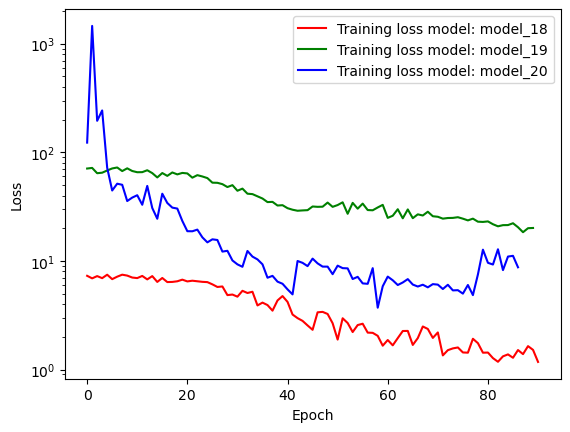

Generating 188 / 64 samples before starting training


KeyboardInterrupt: 

In [128]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    EPOCHS_BETWEEN_PLOTS = 3
    EPOCHS_TO_TRAIN = EPOCHS_BETWEEN_PLOTS*100

    for i in range(0, EPOCHS_TO_TRAIN, EPOCHS_BETWEEN_PLOTS):
        with generator:
            for model in models:
                h = model.fit(
                generator,
                validation_data= (np.array(validation_set), np.array(validation_labels)),
                epochs= EPOCHS_BETWEEN_PLOTS,
                verbose=0
                )
                save_history(model)

        for model in models:
            fig, ax = plt.subplots(1, 2, figsize = (8, 4))
            
            ax[0].plot(model.totalhistory["training_loss"], 'g', label = "Training")
            ax[0].plot(model.totalhistory["validation_loss"], 'b', label = "Validation")
            ax[0].semilogy()
            ax[0].set_xlabel("Epoch")
            ax[0].set_ylabel("Loss")
            ax[0].legend()

            ax[1].plot(model.predict(np.array(validation_set)), validation_labels, '.')
            ax[1].plot(
                np.linspace(-SAMPLE_THICKNESS // 2, SAMPLE_THICKNESS // 2),
                np.linspace(-SAMPLE_THICKNESS // 2, SAMPLE_THICKNESS // 2),
                'k--')
            ax[1].set_xlabel("Predicted z [relative]")
            ax[1].set_ylabel("True z [relative]")

            plt.show()

        group_fig = plt.figure()
        group_ax = group_fig.add_subplot()
        group_ax.semilogy()

        color_cycle = cycler(color=['r', 'g', 'b'])
        group_ax.set_prop_cycle(color_cycle)

        for model in models:
            group_ax.plot(model.totalhistory["training_loss"], label = f"Training loss model: {model.name}")
            #ax.plot(model.totalhistory["validation_loss"], 'b', label = "Validation")
        
        group_ax.legend()
        group_ax.set_xlabel("Epoch")
        group_ax.set_ylabel("Loss")

        plt.show()
else:
    import keras
    model = keras.models.load_model("my_model")


## Visualizing featuremaps

[[0.8941585]]
0.9124181944557382


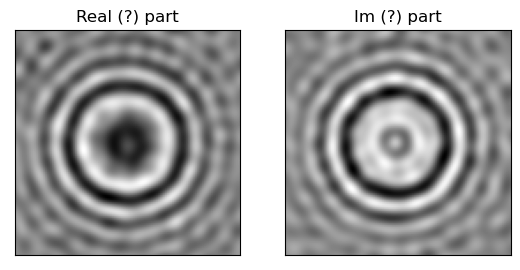

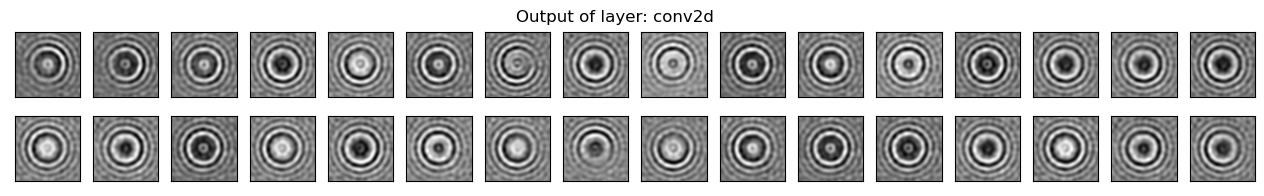

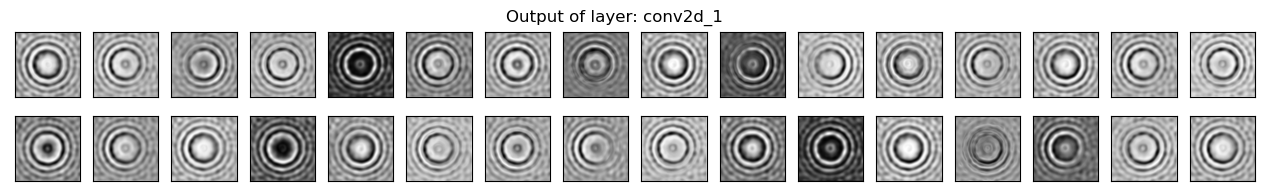

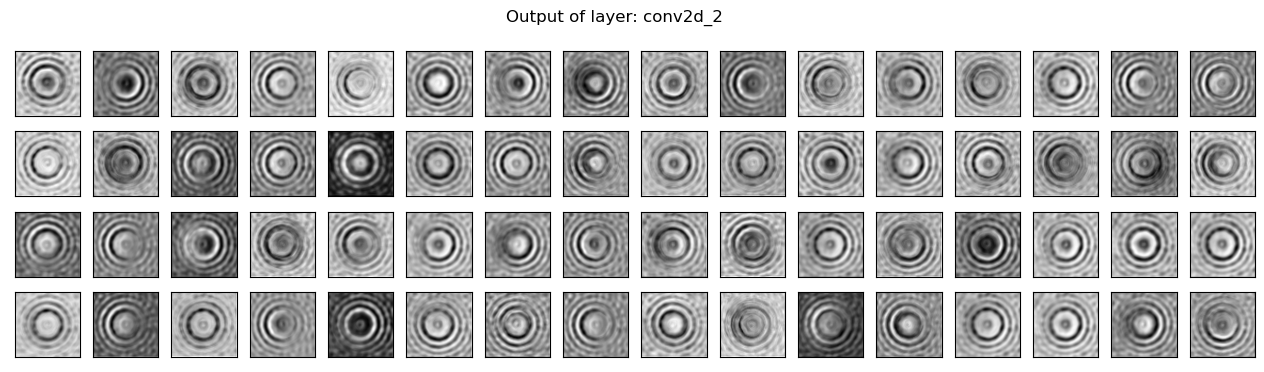

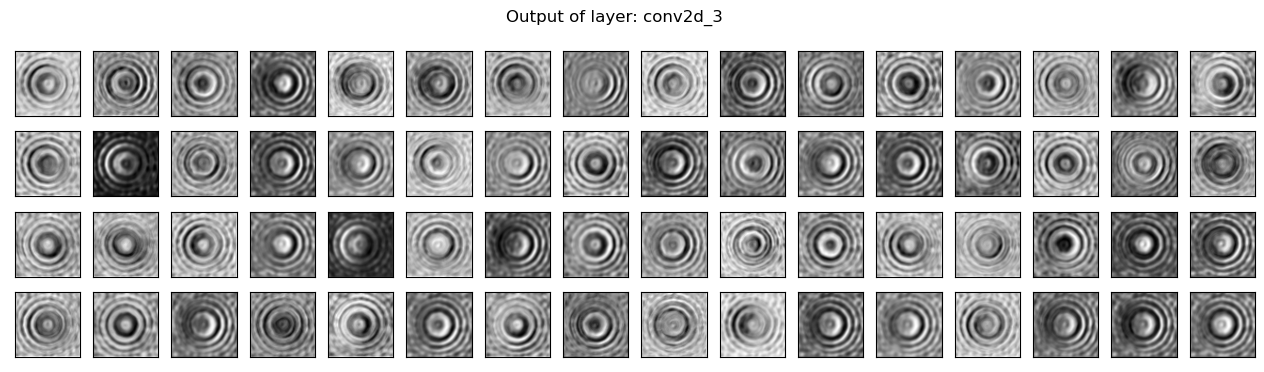

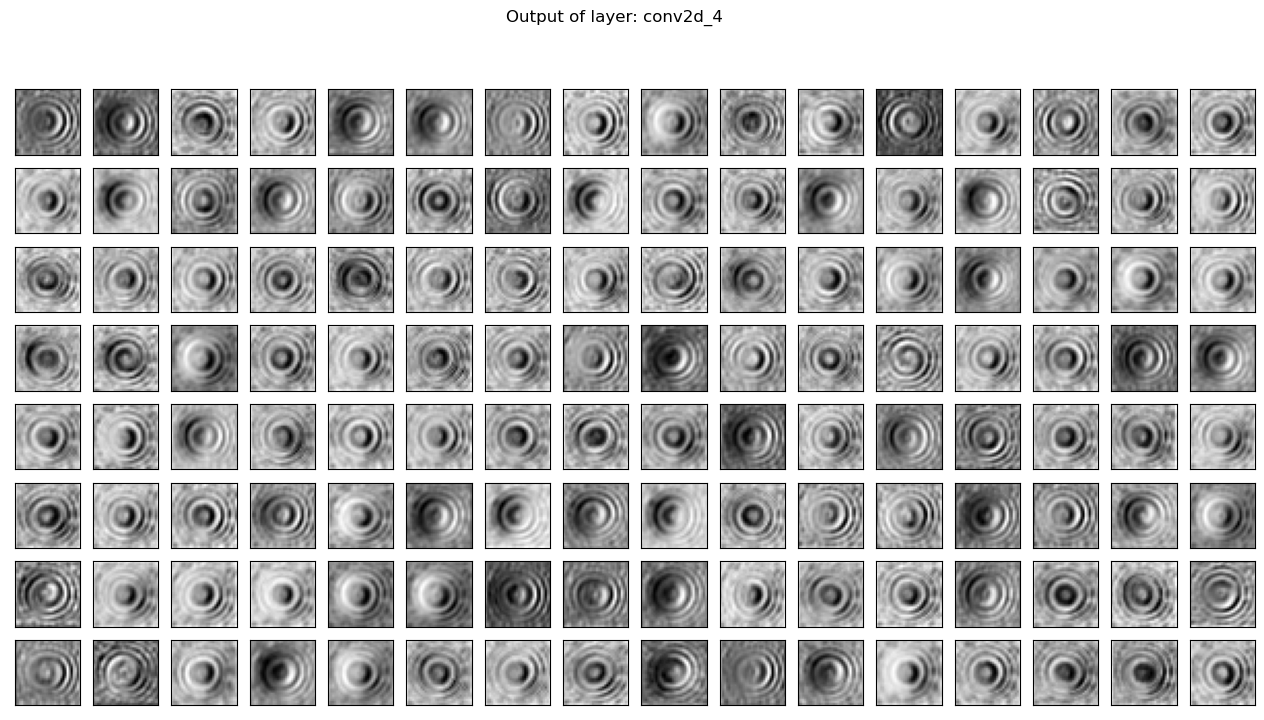

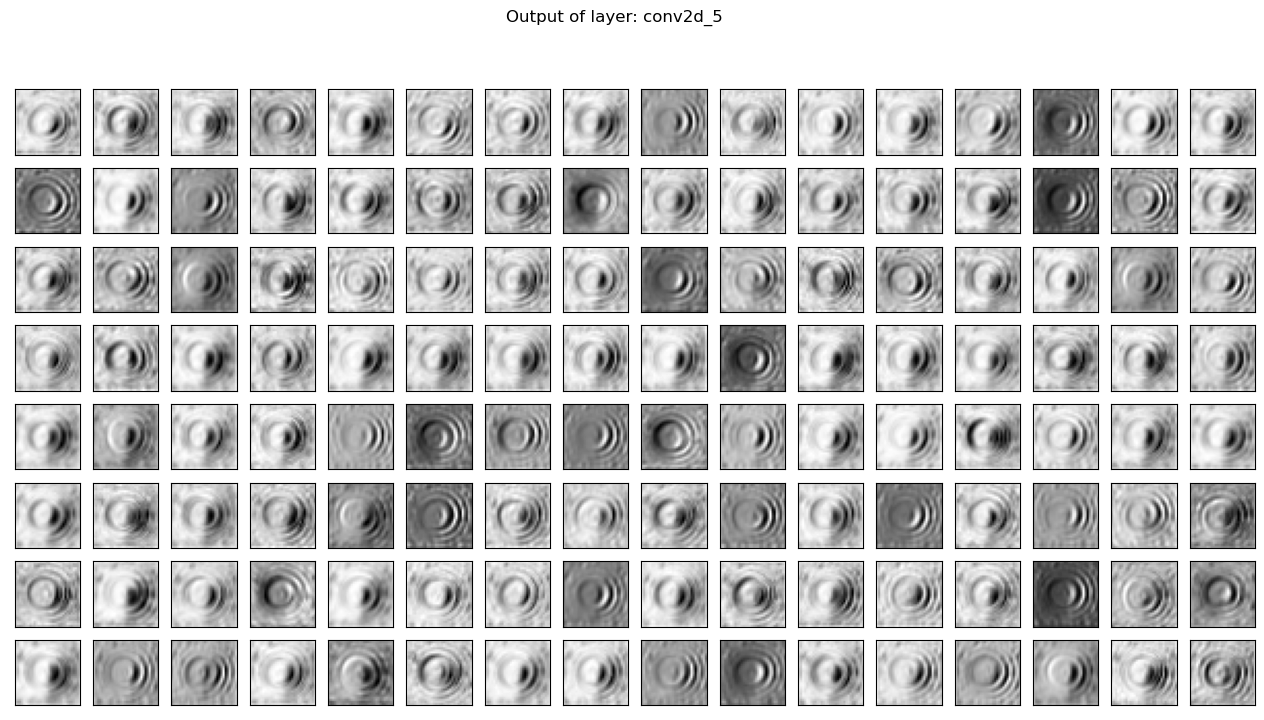

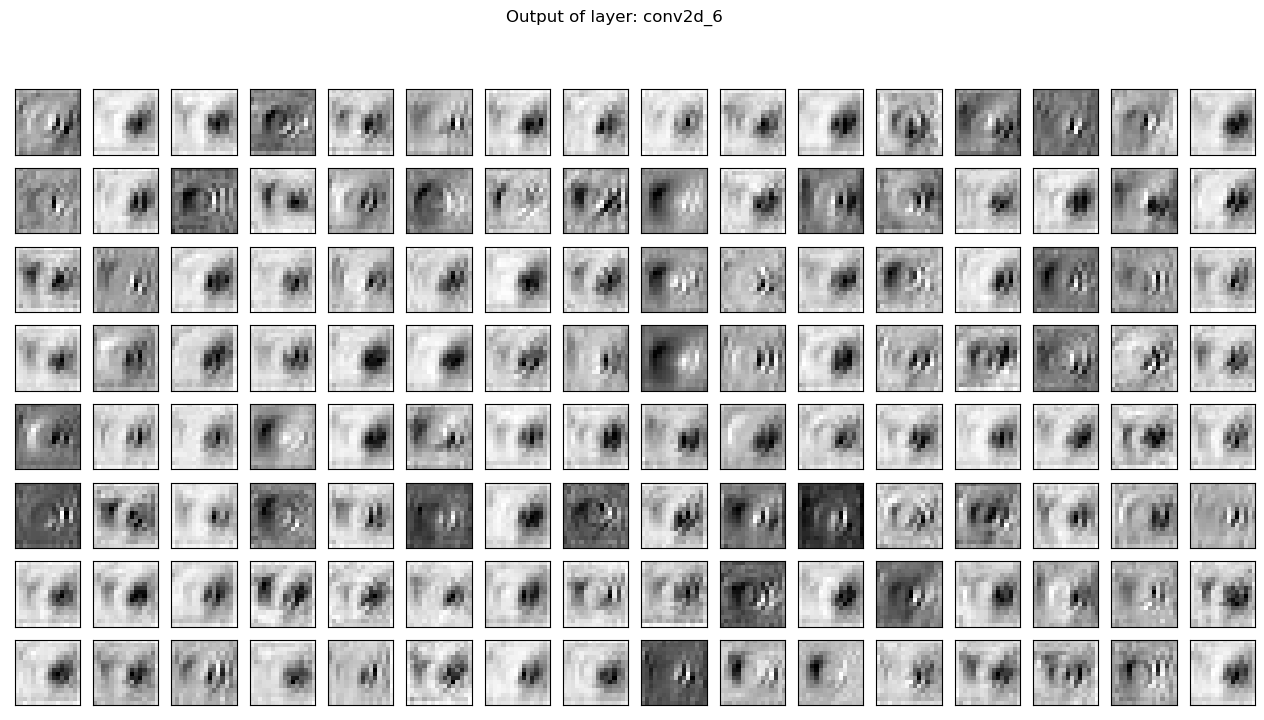

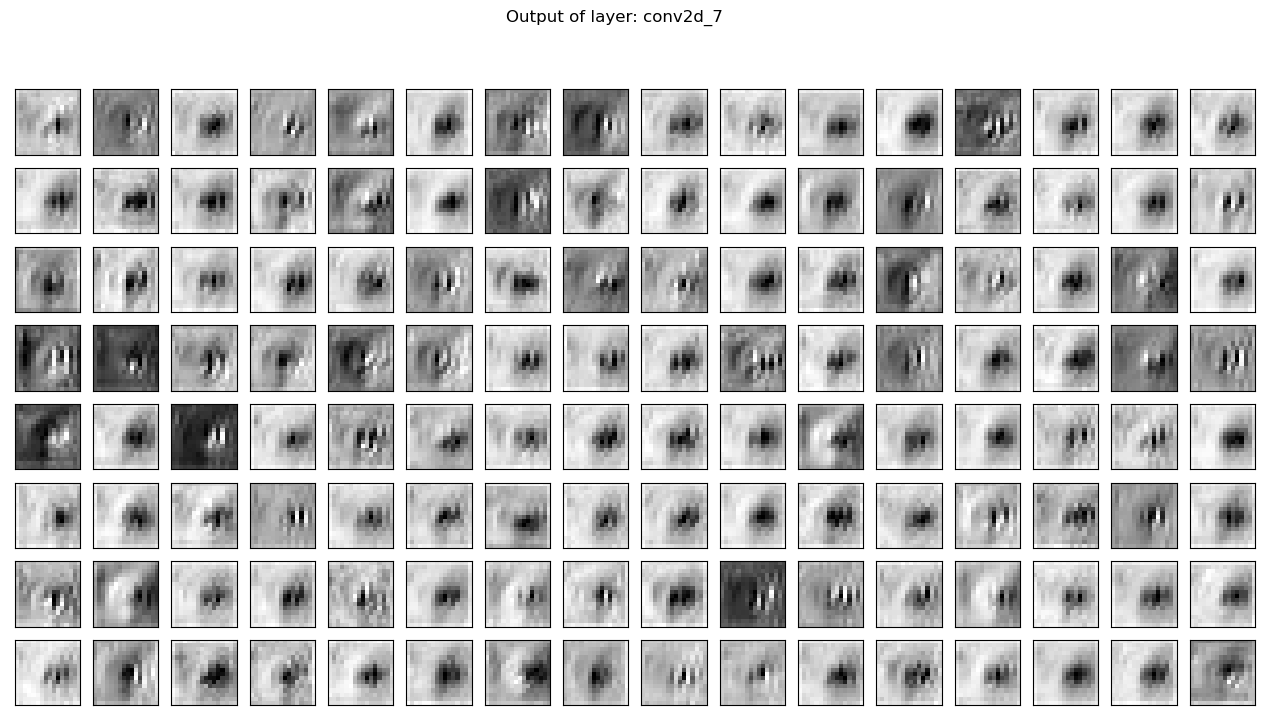

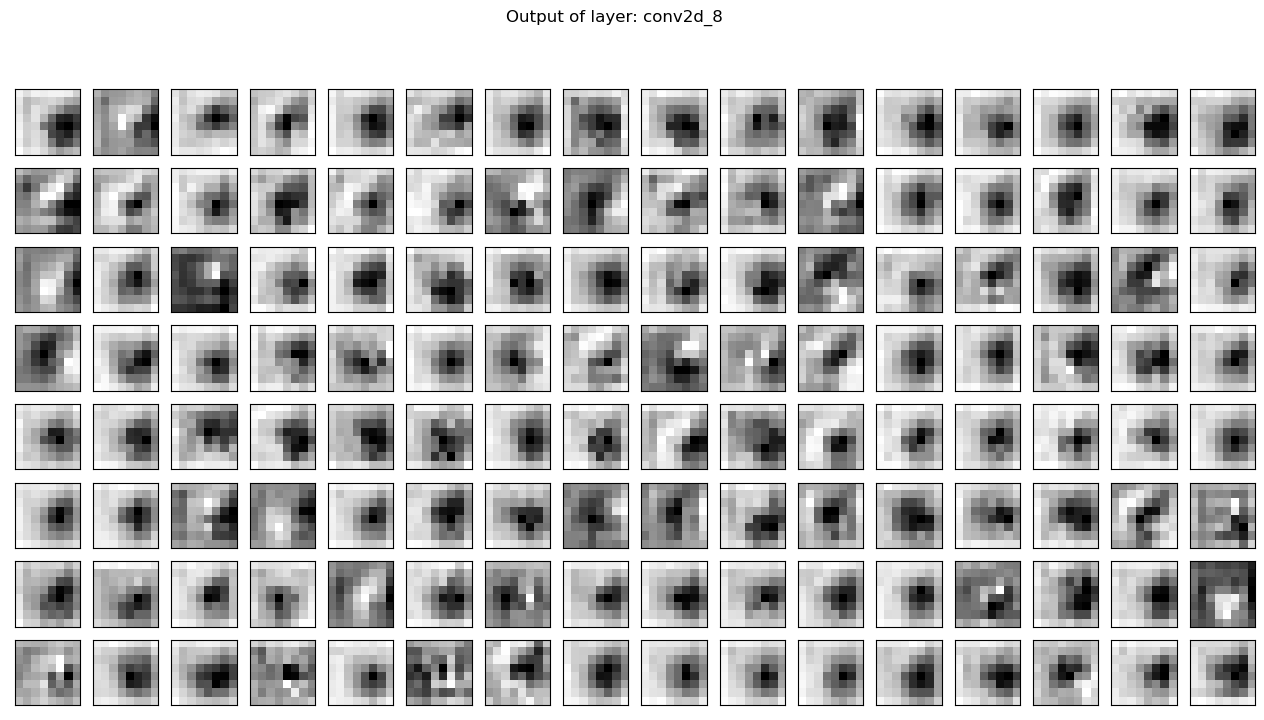

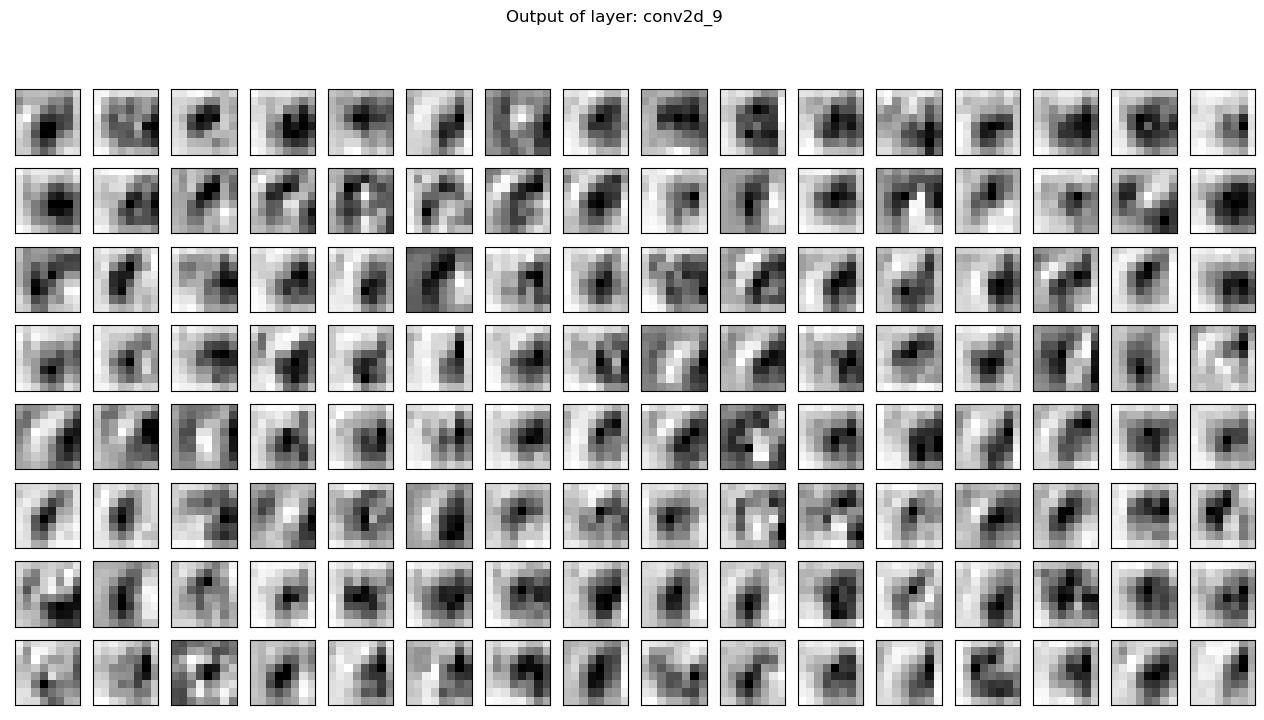

In [73]:
import visualize_feature_maps as vs
import keras

model = keras.models.load_model("sick_gpu_trained_killer_model")

dataset.update()
image_of_particle = dataset.resolve()

vs.visualize_feature_maps(model, image_of_particle, SUBPLOT_WIDTH=16, SUBPLOT_SIZE=1)